### 1. Load the data
Load the training data and display the first few rows to get an overview of the dataset

In [4]:
import pandas as pd

# Load the training data
df = pd.read_csv("data/train.csv")

# Show the first 5 rows
(df.head())

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### 2. Explore the Dataset
We'll check data types, look for missing values, and start understanding the structure of our dataset.

In [5]:
# Check data types and non-null counts
summary_df = pd.DataFrame({
    "Non-Null Count": df.notnull().sum(),
    "Data Type": df.dtypes
})

summary_df.index.name = "Column"
summary_df.reset_index(inplace=True)
summary_df


,Column,Non-Null Count,Data Type
0,id,165034,int64
1,CustomerId,165034,int64
2,Surname,165034,object
3,CreditScore,165034,int64
4,Geography,165034,object
5,Gender,165034,object
6,Age,165034,float64
7,Tenure,165034,int64
8,Balance,165034,float64
9,NumOfProducts,165034,int64


In [6]:
# Check for missing values in each column
df.isnull().sum().to_frame(name="Missing Values")

,Missing Values
Column,
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0


In [7]:
# Show unique values and how many times each appears
df['Geography'].value_counts().to_frame(name='Count').reset_index().rename(columns={'index': 'Geography'})

,Geography,Count
0,France,94215
1,Spain,36213
2,Germany,34606


#### 3. Clean the Data
We’ll drop irrelevant columns, and convert categorical columns Gender and Geography into numeric values to make the data usable for modelling.

In [8]:
# Make a copy of the original DataFrame to keep things safe
df_clean = df.copy()

# Drop unnecessary columns
df_clean = df_clean.drop(['id', 'CustomerId', 'Surname'], axis=1)

# Convert 'Gender' to binary: Male = 1, Female = 0
df_clean['Gender'] = df_clean['Gender'].map({'Male': 1, 'Female': 0})

# Convert 'Geography' to dummy variables (drop_first=True avoids multicollinearity)
df_clean = pd.get_dummies(df_clean, columns=['Geography'], drop_first=True)

# Display the first 5 rows of the cleaned dataset as a DataFrame (not plain print)
df_clean.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,False,False
1,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,False,False
2,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,False,False
3,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,False,False
4,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,False,True


#### 4. Feature Engineering
To help the model, we create new features based on existing ones, like balance-to-salary ratio and a flag for having any balance.

In [9]:
df_clean['BalanceSalaryRatio'] = df_clean['Balance'] / (df_clean['EstimatedSalary'] + 1)

In [10]:
df_clean['HasBalance'] = (df_clean['Balance'] > 0).astype(int)

In [11]:
df_clean[['Balance', 'EstimatedSalary', 'BalanceSalaryRatio', 'HasBalance']].head()

,Balance,EstimatedSalary,BalanceSalaryRatio,HasBalance
0,0.00,181449.97,0.000000,0
1,0.00,49503.50,0.000000,0
2,0.00,184866.69,0.000000,0
3,148882.54,84560.88,1.760634,1
4,0.00,15068.83,0.000000,0


In [12]:
(df_clean.isnull().sum())

CreditScore           0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Geography_Germany     0
Geography_Spain       0
BalanceSalaryRatio    0
HasBalance            0
dtype: int64

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# Define features (X) and target (y)
X = df_clean.drop("Exited", axis=1)
y = df_clean["Exited"]

# Split the data into train and test sets (80/20), stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
print("\n Classification Report:")
display(report_df.round(2))

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"\n ROC AUC Score: {roc_score:.4f}")


Confusion Matrix:


C:\Users\naomi\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predicted 0,Predicted 1
Actual 0,24829,1194
Actual 1,4297,2687



 Classification Report:


,precision,recall,f1-score,support
0,0.85,0.95,0.90,26023.00
1,0.69,0.38,0.49,6984.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.77,0.67,0.70,33007.00
weighted avg,0.82,0.83,0.81,33007.00



 ROC AUC Score: 0.8095


#### 6. Feature Scaling

To help the logistic regression model perform better, we scale the features so they are on a similar range. This helps the model converge and treat all features fairly.


In [14]:
from sklearn.preprocessing import StandardScaler

# Create a scaler
scaler = StandardScaler()

# Fit only on training features, then transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 7. Retrain Logistic Regression with Scaled Data

We retrain the model using the scaled training set to help it converge and possibly improve performance.


In [15]:
# Create and train the logistic regression model again (with more iterations allowed)
log_reg_scaled = LogisticRegression(max_iter=1000, random_state=42)
log_reg_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred_scaled = log_reg_scaled.predict(X_test_scaled)
y_proba_scaled = log_reg_scaled.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
conf_matrix_scaled = pd.DataFrame(
    confusion_matrix(y_test, y_pred_scaled),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix_scaled)

# Classification Report
report_scaled = classification_report(y_test, y_pred_scaled, output_dict=True)
report_scaled_df = pd.DataFrame(report_scaled).T
print("\nClassification Report:")
display(report_scaled_df.round(2))

# ROC AUC Score
roc_score_scaled = roc_auc_score(y_test, y_proba_scaled)
print(f"\nROC AUC Score: {roc_score_scaled:.4f}")


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,24835,1188
Actual 1,4324,2660



Classification Report:


,precision,recall,f1-score,support
0,0.85,0.95,0.90,26023.00
1,0.69,0.38,0.49,6984.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.77,0.67,0.70,33007.00
weighted avg,0.82,0.83,0.81,33007.00



ROC AUC Score: 0.8141


### 8. Train a Decision Tree Classifier

We now train a classification tree (CART) to capture more complex relationships between variables and see if it performs better than logistic regression, especially for detecting churners.


In [16]:
from sklearn.tree import DecisionTreeClassifier

# Create the Decision Tree model
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the model
tree_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_tree = tree_clf.predict(X_test_scaled)
y_proba_tree = tree_clf.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
conf_matrix_tree = pd.DataFrame(
    confusion_matrix(y_test, y_pred_tree),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix_tree)

# Classification Report
report_tree = classification_report(y_test, y_pred_tree, output_dict=True)
report_tree_df = pd.DataFrame(report_tree).T
print("\nClassification Report:")
display(report_tree_df.round(2))

# ROC AUC Score
roc_score_tree = roc_auc_score(y_test, y_proba_tree)
print(f"\nROC AUC Score: {roc_score_tree:.4f}")


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,22590,3433
Actual 1,3184,3800



Classification Report:


,precision,recall,f1-score,support
0,0.88,0.87,0.87,26023.0
1,0.53,0.54,0.53,6984.0
accuracy,0.80,0.80,0.80,0.8
macro avg,0.70,0.71,0.70,33007.0
weighted avg,0.80,0.80,0.80,33007.0



ROC AUC Score: 0.7063


### 9. Hyperparameter Tuning — Decision Tree

Decision trees can easily overfit. We’ll try limiting the depth of the tree and adjusting other parameters to find a better balance between bias and variance.


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model
best_dt = grid_search.best_estimator_

# Predict on test set
y_pred_dt_tuned = best_dt.predict(X_test)
y_proba_dt_tuned = best_dt.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix_dt = pd.DataFrame(
    confusion_matrix(y_test, y_pred_dt_tuned),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix_dt)

# Classification Report
report_dt = classification_report(y_test, y_pred_dt_tuned, output_dict=True)
report_dt_df = pd.DataFrame(report_dt).T
print("\nClassification Report:")
display(report_dt_df.round(2))

# ROC AUC Score
roc_dt_score = roc_auc_score(y_test, y_proba_dt_tuned)
print(f"\nROC AUC Score: {roc_dt_score:.4f}")


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,24727,1296
Actual 1,3244,3740



Classification Report:


,precision,recall,f1-score,support
0,0.88,0.95,0.92,26023.00
1,0.74,0.54,0.62,6984.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.81,0.74,0.77,33007.00
weighted avg,0.85,0.86,0.85,33007.00



ROC AUC Score: 0.8840


In [18]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)


#### 10. Random Forest — Baseline

We train a Random Forest to reduce overfitting by combining multiple decision trees with bagging and random feature selection.

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix_rf = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rf),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix_rf)

# Classification Report
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_rf_df = pd.DataFrame(report_rf).T
print("\nClassification Report:")
display(report_rf_df.round(2))

# ROC AUC Score
roc_rf_score = roc_auc_score(y_test, y_proba_rf)
print(f"\nROC AUC Score: {roc_rf_score:.4f}")


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,24617,1406
Actual 1,3265,3719



Classification Report:


,precision,recall,f1-score,support
0,0.88,0.95,0.91,26023.00
1,0.73,0.53,0.61,6984.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.80,0.74,0.76,33007.00
weighted avg,0.85,0.86,0.85,33007.00



ROC AUC Score: 0.8726


#### 11. AdaBoost — Baseline

Using AdaBoost to improve performance on difficult samples, especially churners, by sequentially combining weak learners.

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Base learner (shallow trees)
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost model
ada_clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

# Train
ada_clf.fit(X_train, y_train)

# Predict
y_pred_ada = ada_clf.predict(X_test)
y_proba_ada = ada_clf.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix_ada = pd.DataFrame(
    confusion_matrix(y_test, y_pred_ada),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix_ada)

# Classification Report
report_ada = classification_report(y_test, y_pred_ada, output_dict=True)
report_ada_df = pd.DataFrame(report_ada).T
print("\nClassification Report:")
display(report_ada_df.round(2))

# ROC AUC Score
roc_ada_score = roc_auc_score(y_test, y_proba_ada)
print(f"\nROC AUC Score: {roc_ada_score:.4f}")


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,24746,1277
Actual 1,3387,3597



Classification Report:


,precision,recall,f1-score,support
0,0.88,0.95,0.91,26023.00
1,0.74,0.52,0.61,6984.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.81,0.73,0.76,33007.00
weighted avg,0.85,0.86,0.85,33007.00



ROC AUC Score: 0.8777


In [21]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialise CatBoost
cat_clf = CatBoostClassifier(
    iterations=100,              # Number of boosting rounds
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0                    # Suppress training output
)

# Train
cat_clf.fit(X_train, y_train)

# Predict
y_pred_cat = cat_clf.predict(X_test)
y_proba_cat = cat_clf.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix_cat = pd.DataFrame(
    confusion_matrix(y_test, y_pred_cat),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:")
display(conf_matrix_cat)

# Classification Report
report_cat = classification_report(y_test, y_pred_cat, output_dict=True)
report_cat_df = pd.DataFrame(report_cat).T
print("\nClassification Report:")
display(report_cat_df.round(2))

# ROC AUC Score
roc_cat_score = roc_auc_score(y_test, y_proba_cat)
print(f"\nROC AUC Score: {roc_cat_score:.4f}")

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,24792,1231
Actual 1,3241,3743



Classification Report:


,precision,recall,f1-score,support
0,0.88,0.95,0.92,26023.00
1,0.75,0.54,0.63,6984.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.82,0.74,0.77,33007.00
weighted avg,0.86,0.86,0.86,33007.00



ROC AUC Score: 0.8890


#### 13. Final Predictions on `test.csv`

We use our best-performing model (CatBoost) to make predictions on the test dataset. This simulates applying the model to new customer data and outputs the predicted probability of churn. Results are saved in `submission.csv`.

In [22]:
# Load test.csv
test_df = pd.read_csv("data/test.csv")

# Preprocess test data to match training
test_processed = test_df.copy()

# Drop unused columns
test_processed = test_processed.drop(['CustomerId', 'Surname'], axis=1)

# Encode Gender
test_processed['Gender'] = test_processed['Gender'].map({'Male': 1, 'Female': 0})

# One-hot encode Geography (drop_first=True)
test_processed = pd.get_dummies(test_processed, columns=['Geography'], drop_first=True)

# Add engineered features
test_processed['BalanceSalaryRatio'] = test_processed['Balance'] / (test_processed['EstimatedSalary'] + 1e-5)
test_processed['HasBalance'] = test_processed['Balance'].apply(lambda x: 1 if x > 0 else 0)

# Reorder to match training columns
test_processed = test_processed[X_train.columns]

# Predict probabilities using best model (CatBoost)
y_test_pred = cat_clf.predict_proba(test_processed)[:, 1]

# Save predictions
submission = pd.DataFrame({
    'id': test_df['id'],
    'Exited': y_test_pred  # probability of churn
})

submission.to_csv("submission.csv", index=False)

print("✅ submission.csv created")


✅ submission.csv created


In [23]:
# Get descriptive stats
desc_stats = submission['Exited'].describe()

# Format and round neatly
desc_df = pd.DataFrame(desc_stats.round(4)).rename(columns={'Exited': 'Predicted Churn Probability'})
desc_df.index.name = 'Statistic'

# Display as styled table
display(desc_df)

,Predicted Churn Probability
Statistic,
count,110023.0000
mean,0.2109
std,0.2582
min,0.0087
25%,0.0315
50%,0.0902
75%,0.2881
max,0.9806


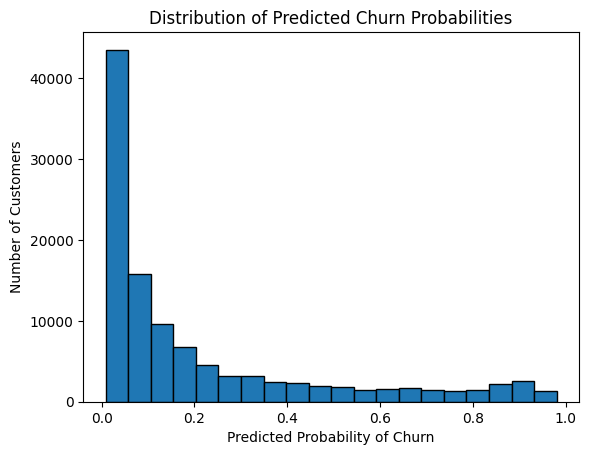

In [24]:
import matplotlib.pyplot as plt

plt.hist(submission['Exited'], bins=20, edgecolor='black')
plt.title("Distribution of Predicted Churn Probabilities")
plt.xlabel("Predicted Probability of Churn")
plt.ylabel("Number of Customers")
plt.show()

In [25]:
# Apply threshold to convert probabilities to binary churn predictions
predicted_churn = (submission['Exited'] >= 0.5).astype(int)

# Get value counts as proportions
churn_proportions = predicted_churn.value_counts(normalize=True).rename_axis('Predicted Class').reset_index(name='Proportion')

# Format and round neatly
churn_proportions['Proportion'] = churn_proportions['Proportion'].round(4)

# Replace 0/1 with labels for clarity
churn_proportions['Predicted Class'] = churn_proportions['Predicted Class'].map({0: 'Not Churned (0)', 1: 'Churned (1)'})

# Display as styled table
display(churn_proportions)

,Predicted Class,Proportion
0,Not Churned (0),0.8479
1,Churned (1),0.1521


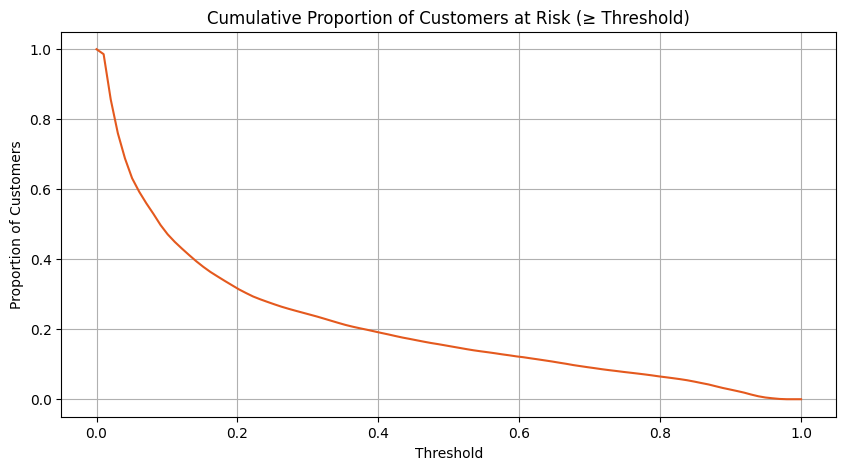

In [26]:
import numpy as np

thresholds = np.linspace(0, 1, 100)
proportions = [(submission['Exited'] >= t).mean() for t in thresholds]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, proportions, color='#E4591E')
plt.title("Cumulative Proportion of Customers at Risk (≥ Threshold)")
plt.xlabel("Threshold")
plt.ylabel("Proportion of Customers")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

probs = pd.Series(submission['Exited'])

for thresh in [0.1, 0.5]:
    pct = (probs >= thresh).mean() * 100
    print(f"Threshold {thresh:>4}: {pct:.1f}% of customers flagged")


Threshold  0.1: 47.3% of customers flagged
Threshold  0.5: 15.2% of customers flagged
